# make_stations_with_ags prototype
Prototype for the script

In [1]:
'''
This script is used to create the stations_with_ags.csv
for the hystreet aggregator. Needs to be run only when
new stations are added.
'''

import os
import requests



# Get Hystreet Locations
headers = {'Content-Type': 'application/json',
           'X-API-Token': os.getenv('HYSTREET_TOKEN')}
res = requests.get('https://hystreet.com/api/locations/', headers=headers)
locations = res.json()



In [2]:
# Search Lat/Lon for Hystreet Locations

from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="everyonecounts")
for location in locations:
    query = location["city"]+" "+location["name"].split("(")[0]
    geoloc = geolocator.geocode(query,exactly_one=True)
    if geoloc==None and "seite" in query:
        # Berlin Kurfürstendamm Nordseite --> Berlin Kurfürstendamm
        query2 = query.replace("Nordseite","").replace("Ostseite","").replace("Südseite","").replace("Westseite","").split("(")[0]
        geoloc = geolocator.geocode(query2,exactly_one=True)
    if geoloc==None:
        print("!!! NOT FOUND: ",query,query2)
        location["lat"]=None
        location["lon"]=None
        location["address"]=None
    else:
        print(query,"==>",geoloc.address)
        location["lat"]=geoloc.latitude
        location["lon"]=geoloc.longitude
        location["address"]=geoloc.address

Augsburg Annastraße ==> Annastraße, Innenstadt, St. Ulrich-Dom, Innenstadt, Augsburg, Bayern, 86150, Deutschland
Oldenburg Lange Straße ==> Lange Straße, Heiligengeistviertel, Innenstadt, Oldenburg, Niedersachsen, 26122, Deutschland
Stuttgart Stiftstraße ==> Stiftstraße, Rathaus, Stuttgart-Mitte, Stuttgart, Baden-Württemberg, 70173, Deutschland
Bocholt Neustraße ==> Neustraße, Altstadt, Stenern, Bocholt, Kreis Borken, Nordrhein-Westfalen, 46399, Deutschland
Köln Hohe Straße  ==> Hohe Straße, Altstadt-Nord, Innenstadt, Köln, Nordrhein-Westfalen, 50667, Deutschland
Hamburg Große Bleichen ==> Große Bleichen, Neustadt, Hamburg, 20354, Deutschland
Hamburg Große Bleichen ==> Große Bleichen, Neustadt, Hamburg, 20354, Deutschland
Würzburg Schönbornstraße ==> Schönbornstraße, Würzburg Altstadt, Würzburg, Bayern, 97070, Deutschland
Flensburg Holm ==> Holm, Westliche Höhe, Flensburg, Schleswig-Holstein, 24937, Deutschland
Braunschweig Sack ==> Sack, Innenstadt, Braunschweig, Niedersachsen, 38100,

Brilon Bahnhofstraße  ==> Bahnhofstraße, Brilon, Hochsauerlandkreis, Nordrhein-Westfalen, 59929, Deutschland
Braunschweig Neue Straße ==> Neue Straße, Innenstadt, Braunschweig, Niedersachsen, 38100, Deutschland
Braunschweig Langer Hof ==> Langer Hof, Innenstadt, Braunschweig, Niedersachsen, 38100, Deutschland
Karlsruhe Kaiserstraße  ==> Kaiserstraße, Innenstadt-West Westlicher Teil, Innenstadt-West, Karlsruhe, Baden-Württemberg, 76133, Deutschland
Köln Ehrenstraße  ==> Ehrenstraße, Altstadt-Nord, Innenstadt, Köln, Nordrhein-Westfalen, 50672, Deutschland
Bonn Remigiusstraße ==> Remigiusstraße, Bonn-Zentrum, Stadtbezirk Bonn, Bonn, Nordrhein-Westfalen, 53111, Deutschland
Stuttgart Königstraße  ==> Königstraße, Neue Vorstadt, Stuttgart-Mitte, Stuttgart, Baden-Württemberg, 70173, Deutschland
Leipzig Hainstraße ==> Hainstraße, Leipzig-Zentrum, Mitte, Leipzig, Sachsen, 04109, Deutschland
Hamburg Spitalerstraße ==> Spitalerstraße, Altstadt, Hamburg, 20095, Deutschland
Hamburg Spitalerstraße =

In [84]:
# Find AGS by measuring distance from location lat/lon to gemeinde lat/lon

import pandas as pd
import geopandas
from scipy.spatial import cKDTree
from geopy import distance

df_ags = pd.read_csv("data-gemeindeschluessel.csv", sep="\t")
df_ags = df_ags[~df_ags["lat"].isna()]
df_ags = df_ags[~df_ags["ags"].isna()]
df_ags = df_ags[df_ags["invalid"]!=1]
df_ags = df_ags.rename(columns={'lat':'lat_ags', 'lon':'lon_ags','name':'name_ags'})

def ckdnearest(gdA, gdB):
    # input two geopandas dataframes
    # for each entry in gdA concatenate the spatially closest element in gdB
    # uses a cKDTree for very efficient lookup
    # https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB) # build spatial index for nB
    dist, idx = btree.query(nA, k=1) # k nearest neighbours of nA in nB
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.iloc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='cKD_dist')], axis=1)
    return gdf

df_locations = pd.DataFrame(locations)
gdf_hy  = geopandas.GeoDataFrame(df_locations, geometry=geopandas.points_from_xy(df_locations["lon"], df_locations["lat"]))
gdf_ags = geopandas.GeoDataFrame(df_ags, geometry=geopandas.points_from_xy(df_ags["lon_ags"], df_ags["lat_ags"]))
merged  = ckdnearest(gdf_hy,gdf_ags)

# validity check: calculate distances between hystreet points and their ags counterparts
merged["distance_m"] = merged.apply(lambda x: int(distance.distance( (x.lon,x.lat),(x.lon_ags,x.lat_ags)).m),axis=1)
print("Please check distance for outliers:")
merged["distance_m"].describe()

C:\Users\Michael\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Please check distance for outliers:


count     127.000000
mean      987.937008
std       801.949725
min        83.000000
25%       356.000000
50%       815.000000
75%      1203.500000
max      3771.000000
Name: distance_m, dtype: float64

In [86]:
# Write output to file
outfile = "stations_with_ags.csv"
outdf = merged[["id","name","city","ags","lat","lon","address","distance_m"]]
outdf = outdf.sort_values(by="id")
outdf = outdf.rename(columns={'id':'stationid'})
outdf.to_csv(outfile, index=False)


# Validation

## Map

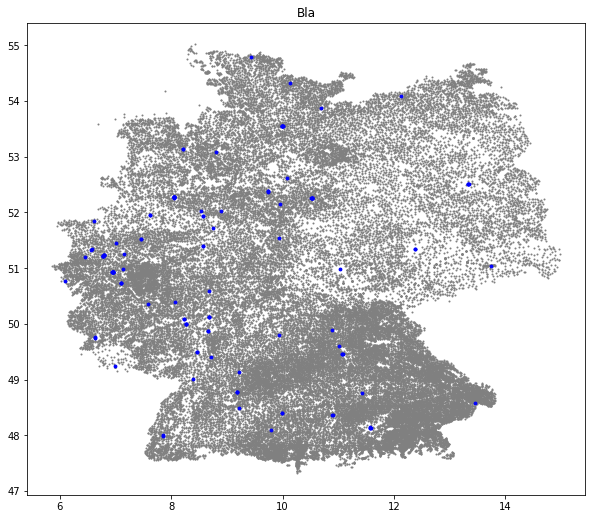

In [87]:
# plot map, where variables are nested within `properties`, 
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 10))
#plt.grid("show")
gdf_ags.plot(ax=ax,markersize=1,color="gray")
gdf_hy.plot(ax=ax,markersize=8,color="blue")
ax.set_title("Bla")

plt.show()

## Validate data
Test by how much old and new station positions differ

### Load data

In [88]:
import pandas as pd
from IPython.display import display

file1 = "../stations_with_ags.csv"
file2 = "stations_with_ags.csv"

with open(file1,"r") as f:
    df1 = pd.read_csv(f)
with open(file2,"r") as f:
    df2 = pd.read_csv(f)
df = df1.join(df2, on="stationid", how='left', lsuffix='old', rsuffix='new', sort=False)
print("--------------\nOLD FILE:")
display(df1.describe())
print(df1.keys())
print("--------------\nNEW FILE:")
display(df2.describe())
print(df2.keys())

--------------
OLD FILE:


,stationid,lon,lat,ags,distanceinmeters
count,117.000000,117.000000,117.000000,1.170000e+02,117.000000
mean,127.111111,8.971354,50.936013,3.192945e+06,710.405872
std,55.872512,1.825708,1.561711,3.901324e+06,540.968477
min,47.000000,6.091435,47.994755,2.000000e+03,5.681937
25%,84.000000,7.461371,49.795161,5.711000e+03,281.143654
50%,123.000000,8.574648,51.044405,1.003000e+06,612.612593
75%,159.000000,10.083537,52.263388,5.774032e+06,923.236858
max,254.000000,13.735441,54.784319,1.471300e+07,2424.485250


Index(['name', 'city', 'stationid', 'lon', 'lat', 'earliest_measurement_at',
       'latest_measurement_at', 'ags', 'ascii', 'distanceinmeters'],
      dtype='object')
--------------
NEW FILE:


,stationid,ags,lat,lon,distance_m
count,127.000000,1.270000e+02,127.000000,127.000000,127.000000
mean,131.866142,4.810596e+06,51.025878,8.956859,987.937008
std,61.223551,3.773963e+06,1.572162,1.845314,801.949725
min,47.000000,1.003000e+03,47.991972,6.092855,83.000000
25%,84.500000,1.001500e+06,49.882458,7.305260,356.000000
50%,125.000000,5.124000e+06,51.224626,8.578640,815.000000
75%,162.500000,6.872004e+06,52.263998,10.043159,1203.500000
max,261.000000,1.605100e+07,54.784201,13.735514,3771.000000


Index(['stationid', 'name', 'city', 'ags', 'lat', 'lon', 'address',
       'distance_m'],
      dtype='object')


### Distances
Calculate distances in meter between old and new positions:

In [89]:
from geopy import distance
merged = df1.merge(df2, on="stationid")
merged["distance"] = merged.apply(lambda x: distance.distance( (x["lat_x"],x["lon_x"]), (x["lat_y"],x["lon_y"]) ), axis=1)
merged["distance"] = merged.apply(lambda x: x["distance"].m, 1) # distance in meter
merged["distance"].describe()

count     121.000000
mean      339.768499
std      1267.045401
min         1.412466
25%        43.974709
50%        97.141962
75%       187.154503
max      9687.414294
Name: distance, dtype: float64